<h3>Who Do We Trust with Our Departed?</h3><h4>A Business Analysis on Funeral Services & Cemeteries in AZ, US</h4>

----------------------------------------------------------------------------------------------------------------------------
PROJECT
----------------------------------------------------------------------------------------------------------------------------

To start with, we first need to prepare our data for analysis. We will be using Apache Spark, through the pyspark library, in order to process this data. We begin by creating a Spark Session.

In [39]:
from pyspark.sql import SparkSession

from pyspark.sql import DataFrame
from pyspark.sql.functions import explode, col
from pyspark.sql.types import StructType, MapType, ArrayType

spark = SparkSession.builder.appName("YelpBusinessAnalysis").getOrCreate()

Next, we need to process our business dataset. Currently, all our data is stored in JSON format. By converting it to Parquet, we can more efficiently process it.

We first read our JSON data into Spark dataframes.

In [2]:
business_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_business.json")
review_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")
user_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_user.json")
tip_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_tip.json")
checkin_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_checkin.json")

24/11/13 17:33:27 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Since our analysis revolves around the 'Funeral Services & Cemeteries' category of businesses in the state of AZ, let's filter it down even further before we create our Parquets.

In [3]:
az_funeral_business_df = business_df.filter(
    (business_df["state"] == "AZ") & 
    (business_df["categories"].contains("Funeral Services & Cemeteries"))
)

Next, we will write these dataframes into Parquet files.

In [4]:
az_funeral_business_df.write.parquet("file:///home/dps/Documents/temp/yelp_az_funeral_business.parquet")
review_df.write.parquet("file:///home/dps/Documents/temp/yelp_review.parquet")
user_df.write.parquet("file:///home/dps/Documents/temp/yelp_user.parquet")
tip_df.write.parquet("file:///home/dps/Documents/temp/yelp_tip.parquet")
checkin_df.write.parquet("file:///home/dps/Documents/temp/yelp_checkin.parquet")

Now that we have created our Parquets, we can finally create temporary views that can aid our data analysis.

In [48]:
az_funeral_business_parquet_df = spark.read.parquet("file:///home/dps/Documents/temp/yelp_az_funeral_business.parquet")
az_funeral_business_parquet_df.createOrReplaceTempView("az_funeral_businesses")

In [42]:
review_parquet_df = spark.read.parquet("file:///home/dps/Documents/temp/yelp_review.parquet")
review_parquet_df.createOrReplaceTempView("az_funeral_reviews")

In [43]:
user_parquet_df = spark.read.parquet("file:///home/dps/Documents/temp/yelp_user.parquet")
user_parquet_df.createOrReplaceTempView("az_funeral_users")

In [44]:
checkin_parquet_df = spark.read.parquet("file:///home/dps/Documents/temp/yelp_checkin.parquet")
checkin_parquet_df.createOrReplaceTempView("az_funeral_checkins")

In [45]:
tip_parquet_df = spark.read.parquet("file:///home/dps/Documents/temp/yelp_tip.parquet")
tip_parquet_df.createOrReplaceTempView("az_funeral_tips")

In [104]:
#imports section
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, StringType, FloatType
import math
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import seaborn as sns
from collections import Counter
import pandas as pd

<h3>Analysis 1</h3>
<h5> Best and Worst Performing Zipcodes for Funeral Services & Cemeteries by Average Rating</h5>

Let's try to identify the best and worst performing zipcodes for 'Funeral Services & Cemeteries' in AZ. We can calculate average rating as a measure of ratings and reviews, which will be used to identify our relevant zipcodes.

In [10]:
avg_rating_zip = spark.sql("""
    SELECT postal_code AS zip_code, ROUND(AVG(stars),2) AS avg_rating, SUM(review_count) AS total_reviews
    FROM az_funeral_businesses
    GROUP BY postal_code
    ORDER BY avg_rating DESC, total_reviews DESC
""")

zip_code_df = avg_rating_zip.toPandas()

In [11]:
# best performing zipcode
best_rating_zip = spark.sql("""
    SELECT postal_code AS zip_code, ROUND(AVG(stars), 2) AS avg_rating, SUM(review_count) AS total_reviews
    FROM az_funeral_businesses
    GROUP BY postal_code
    ORDER BY avg_rating DESC, total_reviews DESC
    LIMIT 1;
""")
best_rating_zip.show()

+--------+----------+-------------+
|zip_code|avg_rating|total_reviews|
+--------+----------+-------------+
|   85714|       5.0|            9|
+--------+----------+-------------+



In [12]:
# worst performing zipcode
worst_rating_zip = spark.sql("""
    SELECT postal_code AS zip_code, ROUND(AVG(stars), 2) AS avg_rating, SUM(review_count) AS total_reviews
    FROM az_funeral_businesses
    GROUP BY postal_code
    ORDER BY avg_rating ASC, total_reviews ASC
    LIMIT 1;
""")
worst_rating_zip.show()

+--------+----------+-------------+
|zip_code|avg_rating|total_reviews|
+--------+----------+-------------+
|   85713|       1.5|           11|
+--------+----------+-------------+



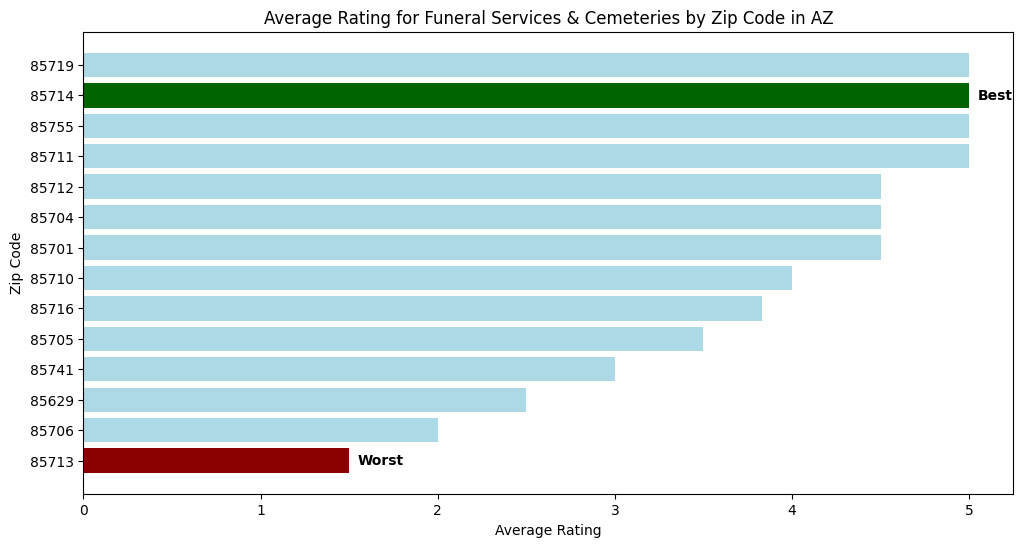

In [72]:
# visualization for our best and worst performing zipcodes

# extract from dataframes
best_zip_code = best_rating_zip.collect()[0]['zip_code']
worst_zip_code = worst_rating_zip.collect()[0]['zip_code']

# create a new column to indicate the best and worst zip codes on plot
zip_code_df['highlight'] = zip_code_df['zip_code'].apply(
    lambda x: 'Best' if x == best_zip_code else ('Worst' if x == worst_zip_code else 'None')
)

# color based on rating threshold and the best/worst zip codes
zip_code_df['color'] = zip_code_df['highlight'].apply(
    lambda x: 'darkgreen' if x == 'Best' else ('darkred' if x == 'Worst' else (
        'lightgreen' if zip_code_df.loc[zip_code_df['highlight'] == x, 'avg_rating'].values[0] >= 3.5 else 'lightblue'
    ))
)

# horizontal bar plot with highlighted best and worst zip codes
zip_code_df = zip_code_df.sort_values(by='avg_rating')

plt.figure(figsize=(12, 6))
bars = plt.barh(zip_code_df['zip_code'], zip_code_df['avg_rating'], color=zip_code_df['color'])

# adding text annotations for the best and worst zip codes
for i, bar in enumerate(bars):
    zip_code = zip_code_df['zip_code'].iloc[i]
    if zip_code == best_zip_code:
        plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, 'Best', va='center', color='black', fontweight='bold')
    elif zip_code == worst_zip_code:
        plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, 'Worst', va='center', color='black', fontweight='bold')

# adding labels and title
plt.xlabel("Average Rating")
plt.ylabel("Zip Code")
plt.title("Average Rating for Funeral Services & Cemeteries by Zip Code in AZ")
plt.show()

<h3>Analysis 2</h3>
<h5>Competitors of Best Business within 10 miles</h5>

From our best performing zipcode, we can infer that a lot of successful businesses in the 'Funeral Services & Cemeteries' industry operate there. 

By identifying competitors of the best business, within a 10-mile radius, we can validate this finding. This will also give us an indicative picture of the competitive landscape in this industry.

In [57]:
# Find the top-rated funeral service
top_rated_service_df = spark.sql(f"""
    SELECT name, city, postal_code, latitude, longitude, stars AS rating, review_count
    FROM az_funeral_businesses
    WHERE postal_code = '{best_zip_code}'
    ORDER BY rating DESC, review_count DESC
    LIMIT 1
""")

top_rated_service_df.show(truncate=False)

+-------------------+------+-----------+-------------+---------------+------+------------+
|name               |city  |postal_code|latitude     |longitude      |rating|review_count|
+-------------------+------+-----------+-------------+---------------+------+------------+
|Family Pet Services|Tucson|85714      |32.1733279672|-110.9219892484|5.0   |9           |
+-------------------+------+-----------+-------------+---------------+------+------------+



In [60]:
top_rated_service = top_rated_service_df.collect()[0]  # Get the top-rated service details
top_service_name = top_rated_service['name']
top_service_name_escaped = top_service_name.replace("'", "''")
top_service_lat = top_rated_service['latitude']
top_service_lon = top_rated_service['longitude']

Next, let's create a distance function to calculate the distance of our top business from its competitors.

In [73]:
# Haversine formula to calculate the distance between two lat/long points
def haversine(lon1, lat1, lon2, lat2):
    R = 3959  # Radius of the Earth in miles
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

# Register the UDF for calculating distance
haversine_udf = udf(haversine, DoubleType())
spark.udf.register("haversine", haversine_udf)

24/11/13 18:24:50 WARN SimpleFunctionRegistry: The function haversine replaced a previously registered function.


<function __main__.haversine(lon1, lat1, lon2, lat2)>

Lastly, let's calculate the distances of the top business' competitors. This results in us finding the most relevant local competitors to our business. Evaluating their offerings and customer engagement can give us an idea as to how we are doing in comparison.

In [74]:
# Calculate distances from the top-rated service and filter based on distance and rating
competitors_with_distance_df = spark.sql("""
    SELECT name, city, postal_code, latitude, longitude, stars AS rating, review_count,
           ROUND(haversine(longitude, latitude, {}, {}), 2) AS distance
    FROM az_funeral_businesses
    WHERE name != '{}'  -- Exclude the top-rated business itself
    AND haversine(longitude, latitude, {}, {}) <= 10  -- Filter for businesses within 10 miles
    AND stars > 3.5  -- Filter for businesses with a rating above 3.5
    ORDER BY distance ASC
""".format(top_service_lon, top_service_lat, top_service_name_escaped, top_service_lon, top_service_lat))

# Show competitors with distances
competitors_with_distance_df.show(truncate=False)

+---------------------------------------+------+-----------+----------+------------+------+------------+--------+
|name                                   |city  |postal_code|latitude  |longitude   |rating|review_count|distance|
+---------------------------------------+------+-----------+----------+------------+------+------------+--------+
|Hudgel's-Swan Funeral Home             |Tucson|85711      |32.2052163|-110.8917541|5.0   |6           |2.83    |
|Carrillo's Tucson Mortuary             |Tucson|85701      |32.218959 |-110.971086 |4.5   |7           |4.26    |
|Adair Funeral Homes                    |Tucson|85716      |32.2354851|-110.9122441|4.0   |16          |4.33    |
|Bring's Broadway Chapel                |Tucson|85710      |32.2205185|-110.8443954|4.0   |10          |5.59    |
|Angel Valley Funeral Home              |Tucson|85716      |32.2533359|-110.9359011|4.0   |13          |5.59    |
|East Lawn Palms Mortuary               |Tucson|85712      |32.2541077|-110.8690292|4.0 

<h3>Analysis 3</h3>
<h5>Sentiment Analysis of Reviews by City</h5>

For an industry revolving around a sensitive topic such as death, there is always scope for emotional bias in reviews; both positive and negative. This could influence customers and potentially hinder growth.

By analyzing review sentiments from different cities in AZ, we can get a perspective on how well a 'Funeral Services & Cemeteries' business would be received by people there.

In [99]:
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Define and register preprocess_text function
stop_words = set(stopwords.words("english"))
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Register the UDF for preprocessing
spark.udf.register("preprocess_text", preprocess_text, StringType())

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()
def get_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']  # Return compound score

# Register the UDF for sentiment analysis
spark.udf.register("get_sentiment_score", get_sentiment, FloatType())

24/11/13 18:43:14 WARN SimpleFunctionRegistry: The function preprocess_text replaced a previously registered function.
24/11/13 18:43:15 WARN SimpleFunctionRegistry: The function get_sentiment_score replaced a previously registered function.


<function __main__.get_sentiment(text)>

In [100]:
# Filter positive and negative reviews, apply preprocessing and sentiment analysis, and store as temp views
spark.sql("""
    CREATE OR REPLACE TEMP VIEW positive_reviews_with_details AS
    SELECT r.business_id, r.stars, r.text, b.city, b.state, b.postal_code, b.hours,
           get_sentiment_score(preprocess_text(r.text)) AS sentiment_score
    FROM az_funeral_reviews r
    JOIN az_funeral_businesses b ON r.business_id = b.business_id
    WHERE r.stars >= 4
""")

spark.sql("""
    CREATE OR REPLACE TEMP VIEW negative_reviews_with_details AS
    SELECT r.business_id, r.stars, r.text, b.city, b.state, b.postal_code, b.hours,
           get_sentiment_score(preprocess_text(r.text)) AS sentiment_score
    FROM az_funeral_reviews r
    JOIN az_funeral_businesses b ON r.business_id = b.business_id
    WHERE r.stars <= 2
""")

# Combine positive and negative reviews into a single view
spark.sql("""
    CREATE OR REPLACE TEMP VIEW all_reviews AS
    SELECT business_id, city, sentiment_score FROM positive_reviews_with_details
    UNION ALL
    SELECT business_id, city, sentiment_score FROM negative_reviews_with_details
""")

# Calculate the average sentiment score per city
result = spark.sql("""
    SELECT city, AVG(sentiment_score) AS avg_sentiment_score
    FROM all_reviews
    GROUP BY city
    ORDER BY avg_sentiment_score DESC
""")

# Convert result to pandas for further use
result_pandas = result.toPandas()

Since we've been able to calculcate the average sentiment scores for different cities, we can gauge the local customer attitude towards businesses in this category. Negative sentiment may potentially play a role in nudging customers to explore options in other locations.

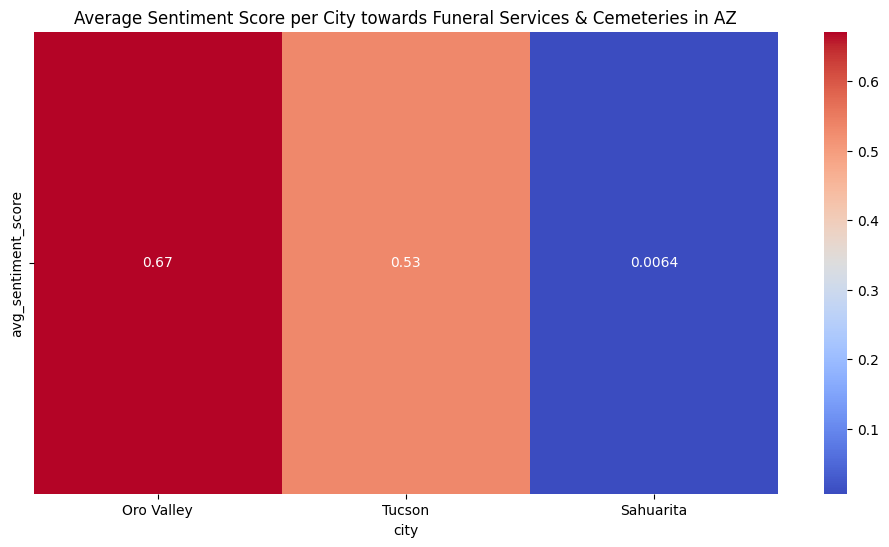

In [103]:
# Set up the seaborn heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(result_pandas.set_index('city').T, annot=True, cmap='coolwarm', cbar=True)
plt.title('Average Sentiment Score per City towards Funeral Services & Cemeteries in AZ')
plt.show()

<h3>Analysis 4</h3>
<h5>Word Frequency Analysis of Positive Reviews in Best Performing City vs. Negative Reviews in Worst Performing City</h5>

Now that we know the sentiments towards Funeral Services & Cemeteries businesses greatly vary by city, it would help to understand what people tend to make note of in their reviews.

This would not only give a deeper understanding of what customers value but also shed light on patterns or trends other data doesn't accurately capture.

In [114]:
spark.sql("""
    CREATE OR REPLACE TEMP VIEW best_city AS
    SELECT city
    FROM az_funeral_businesses
    GROUP BY city
    ORDER BY AVG(stars) DESC
    LIMIT 1;
""")

spark.sql("""
    CREATE OR REPLACE TEMP VIEW worst_city AS
    SELECT city
    FROM az_funeral_businesses
    GROUP BY city
    ORDER BY AVG(stars) ASC
    LIMIT 1;
""")

DataFrame[]

In [115]:
# Positive reviews from the best city
best_city_positive_reviews = spark.sql("""
    SELECT r.text
    FROM az_funeral_reviews r
    JOIN az_funeral_businesses b ON r.business_id = b.business_id
    JOIN best_city bc ON b.city = bc.city
    WHERE r.stars >= 4
""").toPandas()

# Negative reviews from the worst city
worst_city_negative_reviews = spark.sql("""
    SELECT r.text
    FROM az_funeral_reviews r
    JOIN az_funeral_businesses b ON r.business_id = b.business_id
    JOIN worst_city wc ON b.city = wc.city
    WHERE r.stars <= 2
""").toPandas()

In [116]:
# Preprocess the reviews
best_city_positive_reviews['processed_text'] = best_city_positive_reviews['text'].apply(preprocess_text)
worst_city_negative_reviews['processed_text'] = worst_city_negative_reviews['text'].apply(preprocess_text)

# Combine all processed text into a single string for each set
positive_reviews_text = ' '.join(best_city_positive_reviews['processed_text'])
negative_reviews_text = ' '.join(worst_city_negative_reviews['processed_text'])

# Function to get the most common words
def get_most_common_words(text, num_words=20):
    words = re.findall(r'\w+', text.lower())
    word_counts = Counter(words)
    return word_counts.most_common(num_words)

# Get the most common words for positive and negative reviews
positive_most_common_words = get_most_common_words(positive_reviews_text)
negative_most_common_words = get_most_common_words(negative_reviews_text)

# Convert to DataFrames for plotting
positive_df = pd.DataFrame(positive_most_common_words, columns=['Word', 'Frequency'])
negative_df = pd.DataFrame(negative_most_common_words, columns=['Word', 'Frequency'])

/tmp/ipykernel_3124/913421863.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=positive_df, ax=axes[0], palette='crest')
/tmp/ipykernel_3124/913421863.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=negative_df, ax=axes[1], palette='flare')


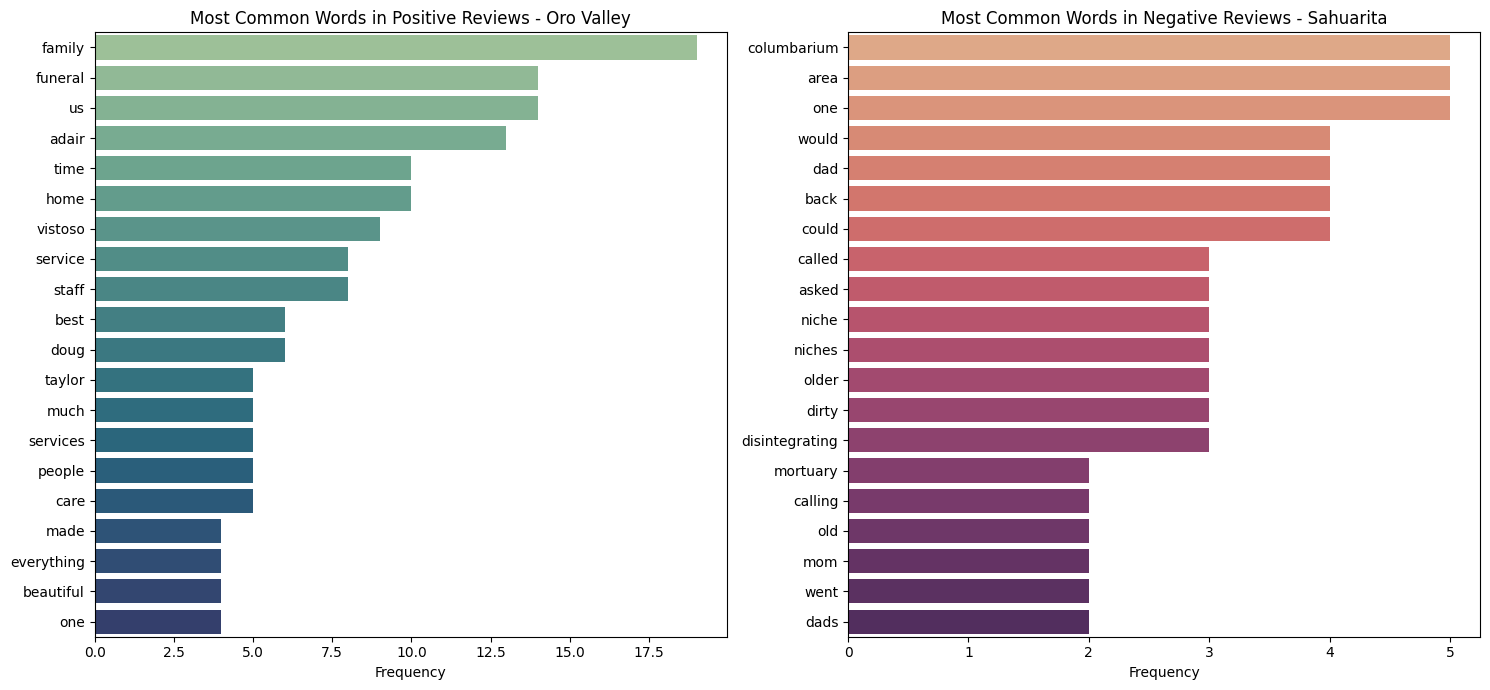

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Retrieve city names
best_city_name = spark.sql("SELECT city FROM best_city").first()[0]
worst_city_name = spark.sql("SELECT city FROM worst_city").first()[0]

# Plot for positive reviews
sns.barplot(x='Frequency', y='Word', data=positive_df, ax=axes[0], palette='crest')
axes[0].set_title(f'Most Common Words in Positive Reviews - {best_city_name}')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('')

# Plot for negative reviews
sns.barplot(x='Frequency', y='Word', data=negative_df, ax=axes[1], palette='flare')
axes[1].set_title(f'Most Common Words in Negative Reviews - {worst_city_name}')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

<h3>Analysis 5</h3>
<h5>Correlation between Customer Engagement (Tips & Checkins) and Business Performance</h5>

Lastly, we want to understand the extent of impact that customer engagement has on a business' rating. Are establishments popular because of footfall alone? Or are tips from customers giving them more visibility?

In [118]:
spark.sql("""
    CREATE OR REPLACE TEMP VIEW business_checkins AS
    SELECT 
        business_id,
        COUNT(*) AS checkins_count
    FROM az_funeral_checkins
    GROUP BY business_id
""")

DataFrame[]

In [119]:
spark.sql("""
    CREATE OR REPLACE TEMP VIEW business_tips AS
    SELECT 
        business_id,
        COUNT(*) AS tips_count
    FROM az_funeral_tips
    GROUP BY business_id
""")

DataFrame[]

In [120]:
spark.sql("""
    CREATE OR REPLACE TEMP VIEW business_engagement AS
    SELECT 
        b.business_id,
        b.stars AS business_rating,
        COALESCE(c.checkins_count, 0) AS checkins_count,
        COALESCE(t.tips_count, 0) AS tips_count
    FROM az_funeral_businesses b
    LEFT JOIN business_checkins c
    ON b.business_id = c.business_id
    LEFT JOIN business_tips t
    ON b.business_id = t.business_id
""")

DataFrame[]

In [121]:
# Fetch the data from the business_engagement view
business_engagement_df = spark.sql("SELECT * FROM business_engagement").toPandas()

# Calculate the correlation matrix
correlation_matrix = business_engagement_df[['business_rating', 'checkins_count', 'tips_count']].corr()
print(correlation_matrix)

                 business_rating  checkins_count  tips_count
business_rating         1.000000        0.449998    0.142103
checkins_count          0.449998        1.000000    0.216930
tips_count              0.142103        0.216930    1.000000


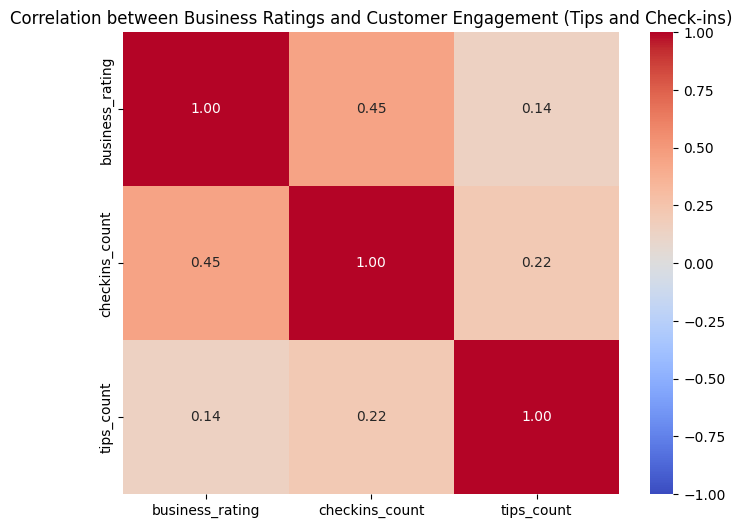

In [152]:
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation between Business Ratings and Customer Engagement (Tips and Check-ins)')
plt.show()